<font size=6><b>Bike Sharing Demand - ML

<img src="./logo.png">
* ref : https://www.kaggle.com/competitions/bike-sharing-demand/data <br>
* ref : https://dacon.io/competitions/official/235985/data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score,GridSearchCV,KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.ensemble     import RandomForestRegressor
from sklearn.tree         import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# ---- 추가 모델
from sklearn.ensemble     import AdaBoostRegressor, VotingRegressor
from xgboost              import XGBRegressor
from lightgbm             import LGBMRegressor

# Data Load

In [3]:
train = pd.read_csv("./train.csv", parse_dates=['datetime'])
test  = pd.read_csv("./test.csv" , parse_dates=['datetime'])

In [4]:
df_list = [train, test]
for df in df_list:
    df.rename(columns = {'datetime' : 'regdate', 'count' : 'regcount'}, inplace = True)
    df.columns = df.columns.str.lower()
    print(df.info())    
    print("====="*10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   regdate     10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  regcount    10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dty

## 점수보기

# Feature Engineering

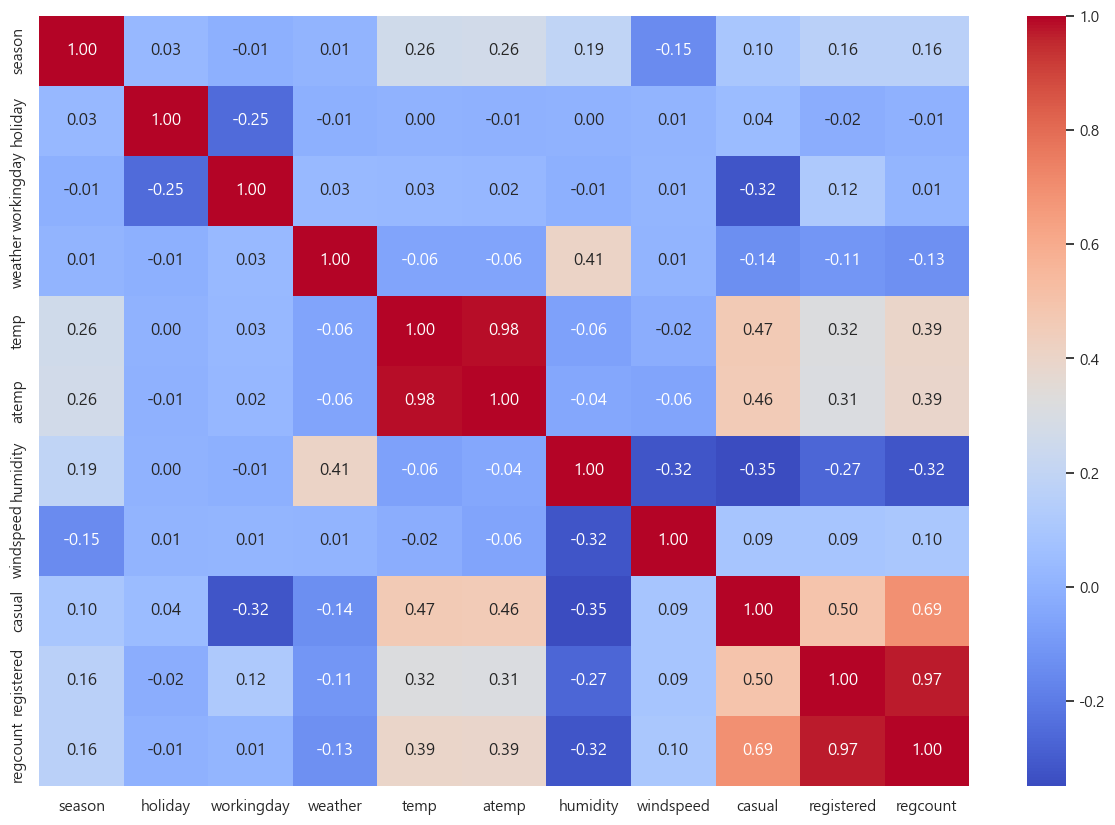

In [5]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()
# m-season, temp-atemp, w-daytype --> 다중공선 처리하기

## windspeed 0 채우기

In [6]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [7]:
def my_fill_windspeed(df):
    target  = df[['regcount','casual','registered', 'regdate']]
    df = df.drop(['regcount','casual','registered','regdate'], axis=1)
    
    df1   = df[df['windspeed'] != 0]
    y_df1 = df1['windspeed']
    X_df1 = df1.drop('windspeed', axis=1)
    
    rf = LGBMRegressor(random_state=0)  #RandomForestRegressor(random_state=11)
    X_df1_8, X_df1_2, y_df1_8, y_df1_2 = train_test_split(X_df1, y_df1, test_size=0.2, random_state=11)
    rf.fit(X_df1_8, y_df1_8)
    
    pred = rf.predict(X_df1_2)
    mse_score = mean_squared_error(y_df1_2, pred)
    print("RMSE : ", np.sqrt(mse_score) )

    df0 = df[df['windspeed'] == 0]
    y_df0 = df0['windspeed']
    X_df0 = df0.drop('windspeed', axis=1)
    pred = rf.predict(X_df0)
    widx = X_df0.index.values
    df.loc[widx, 'windspeed'] = pred
    
    return pd.concat([df, target], axis=1)

In [8]:
df = pd.concat([train, test], axis=0, ignore_index=True)
train_idx = df.iloc[:train.shape[0], :].index
test_idx  = df.iloc[train.shape[0]:, :].index
#---------------------------------
df = my_fill_windspeed(df)
#---------------------------------
train = df.loc[train_idx]
test  = df.loc[test_idx]
test = test.drop(['casual', 'registered', 'regcount'], axis=1)
test = test.reset_index(drop=True)

RMSE :  5.427882362943079


## 파생피쳐
* regdate
* day_type

In [9]:
df_list = [train, test]
df_name = ['train', 'test']
for i, df in enumerate(df_list):
    df['y'] = df['regdate'].dt.year
    df['m'] = df['regdate'].dt.month
    df['d'] = df['regdate'].dt.day
    df['h'] = df['regdate'].dt.hour
    df['w'] = df['regdate'].dt.dayofweek
    #df['woy'] = df['regdate'].dt.weekofyear
    
    
    df['day_type'] = 0
    df['day_type'] = np.where( (df['holiday']==0) & (df['workingday'] == 1),   1,  df['day_type'])
    df['day_type'] = np.where( (df['holiday']==1) & (df['workingday'] == 0),   2,  df['day_type'])
    
    df['peak']   = df[['h', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['h'] == 8 or 17 <= x['h'] <= 18 or 12 <= x['h'] <= 12)) or (x['workingday'] == 0 and  10 <= x['h'] <= 19)], axis = 1)
    df['ideal']  = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
    df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
    
    #sandy
    df['holiday'] = df[['m', 'd', 'holiday', 'y']].apply(lambda x: (x['holiday'], 1)[x['y'] == 2012 and x['m'] == 10 and (x['m'] in [30])], axis = 1)
    #christmas day and others
    df['holiday'] = df[['m', 'd', 'holiday']].apply(lambda x: (x['holiday'], 1)[x['m'] == 12 and (x['m'] in [24, 26, 31])], axis = 1)
    df['workingday'] = df[['m', 'd', 'workingday']].apply(lambda x: (x['workingday'], 0)[x['m'] == 12 and x['m'] in [24, 31]], axis = 1)
    
    
    if i == 0 : # 아웃라이어 : train만 삭제
        #------------------------------------------------
        # windspeed는 0채우기 후 아웃라이어로 한꺼번에 이상치 삭제
        # 아웃라이어 삭제 : 주의주의주의 train만 지운다
        # df == train 넣고 호출
        #------------------------------------------------
        del_idx_list = []
        #idx = df[df['weather']==4].index
        #del_idx_list.extend(idx)
        idx = df[df['temp']>40].index
        del_idx_list.extend(idx)
        idx = df[df['windspeed']>50].index
        del_idx_list.extend(idx)
        df.drop(del_idx_list, axis=0, inplace=True)

    
    #---------(연속형피쳐:로그스케일링) ---------------
    # 'temp', 'atemp','humidity', 'windspeed'
    #------------------------------------------------
    df['temp']      = np.log1p( df['temp'] )
    df['atemp']     = np.log1p( df['atemp'] )
    df['humidity']  = np.log1p( df['humidity'] )
    df['windspeed'] = np.log1p( df['windspeed'] )
    
    #------------------------------------------------
    # 다중공선
    # 'temp', 'atemp'
    # 'season', 'm'
    # 'w', 'day_type'
    #------------------------------------------------
    df = df.drop(['atemp'], axis=1)
    # X = X.drop(['season'], axis=1)
    # X = X.drop(['day_type'], axis=1)
    
    
    #------------------------------------------------
    # 이산형 피쳐 원핫인코딩
    # ['season', 'weather','m', 'y', 'h', 'w', 'day_type']
    df = pd.get_dummies(df, columns=['season', 'weather','m', 'y', 'h', 'w', 'day_type'])
    
    #------------------------------------------------
    #X = df.drop(['regcount','casual','registered'], axis=1)
    df.drop('d', axis=1, inplace=True)
    df = df.set_index('regdate')
    
    #------------------------------------------------
    #print(df.info())
    print(df_name[i])
    globals()[df_name[i]] = df.copy()

train
test


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     6493 non-null   int64  
 1   workingday  6493 non-null   int64  
 2   temp        6493 non-null   float64
 3   humidity    6493 non-null   float64
 4   windspeed   6493 non-null   float64
 5   peak        6493 non-null   int64  
 6   ideal       6493 non-null   int64  
 7   sticky      6493 non-null   int64  
 8   season_1    6493 non-null   uint8  
 9   season_2    6493 non-null   uint8  
 10  season_3    6493 non-null   uint8  
 11  season_4    6493 non-null   uint8  
 12  weather_1   6493 non-null   uint8  
 13  weather_2   6493 non-null   uint8  
 14  weather_3   6493 non-null   uint8  
 15  weather_4   6493 non-null   uint8  
 16  m_1         6493 non-null   uint8  
 17  m_2         6493 non-null   uint8  
 18  m_3         6493 non-null   uint

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10881 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10881 non-null  int64  
 1   workingday  10881 non-null  int64  
 2   temp        10881 non-null  float64
 3   humidity    10881 non-null  float64
 4   windspeed   10881 non-null  float64
 5   regcount    10881 non-null  float64
 6   casual      10881 non-null  float64
 7   registered  10881 non-null  float64
 8   peak        10881 non-null  int64  
 9   ideal       10881 non-null  int64  
 10  sticky      10881 non-null  int64  
 11  season_1    10881 non-null  uint8  
 12  season_2    10881 non-null  uint8  
 13  season_3    10881 non-null  uint8  
 14  season_4    10881 non-null  uint8  
 15  weather_1   10881 non-null  uint8  
 16  weather_2   10881 non-null  uint8  
 17  weather_3   10881 non-null  uint8  
 18  weather_4   10881 non-null  uin

# 학습

## 타켓 선정
* 답안지 : count 제출
* regcount(A패턴)  = registered(A2패턴) + casual (B패턴) 
* <font color=red><b>registered(A2패턴) + casual (B패턴)  --> 이 값을 답안으로 제출

## 최종피쳐 선정

In [12]:
train.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'regcount',
       'casual', 'registered', 'peak', 'ideal', 'sticky', 'season_1',
       'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6',
       'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'y_2011', 'y_2012', 'h_0',
       'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
       'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
       'h_20', 'h_21', 'h_22', 'h_23', 'w_0', 'w_1', 'w_2', 'w_3', 'w_4',
       'w_5', 'w_6', 'day_type_0', 'day_type_1', 'day_type_2'],
      dtype='object')

<pre>
타겟(1) : 'casual' + 'registered'
타겟(2) : 'regcount'


'd' 피쳐 삭제
('m', 'h'),  'y', 'd' -->'w'


(+)3개 : 'holiday', 'workingday', 'day_type'
(+)2개 : 'holiday', 'workingday'
(+)1개 : 'day_type'


'weather', 'humidity',  'season', 
(+)'windspeed' : 'h' 비례? / 'm' 반비례?


다중공선 : (상관계수가 높은 경우)
'regcount' 'registered' 'casual' : 0.97  --> 'regcount' vs. 'registered'+'casual'
'temp' 'atemp'                   : 0.98  --> 'atemp' drop

선택적으로 모델에 적용
(+)'w' 'day_type' : -0.78
(+)'season' 'm'   : 0.97


* ('m', 'h'),  'y', 'w', 'weather', 'humidity',  'season', 'temp'
* (+)'windspeed'
* (+)('holiday', 'workingday'), ('day_type')
* (+)('w' 'day_type') : -0.78
* (+)('m') 'season'    : 0.97


## 학습 & 평가
* ref : https://suboptimal.wiki/explanation/mse/

*  $ RMSLE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{log(Y_i+1) - log(\hat{Y_i}+1)}{N}\Big)^2}}$

In [13]:
# ! pip install xgboost
# ! pip install lightgbm 

## 공통함수

* class sklearn.linear_model.Ridge(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, solver='auto', positive=False, random_state=None)
* class sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

In [14]:
train.head()

,holiday,workingday,temp,humidity,windspeed,regcount,casual,registered,peak,ideal,sticky,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,y_2011,y_2012,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,w_0,w_1,w_2,w_3,w_4,w_5,w_6,day_type_0,day_type_1,day_type_2
regdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,2.383243,4.406719,1.933883,16.0,3.0,13.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2011-01-01 01:00:00,0,0,2.304583,4.394449,1.976391,40.0,8.0,32.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2011-01-01 02:00:00,0,0,2.304583,4.394449,1.976391,32.0,5.0,27.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2011-01-01 03:00:00,0,0,2.383243,4.330733,1.952949,13.0,3.0,10.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2011-01-01 04:00:00,0,0,2.383243,4.330733,1.952949,1.0,0.0,1.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


> 피쳐 학습에 가담한 주요피쳐 보기 --> fit() 하고 난 후 찍어보기
- 분류 : feature importance    --> ABOOST, DecisionTreeRegressor, XGBRegressor, LGBMRegressor
- 회기 : 회기계수(coef) 
* tree model에는 회기라고 하더라도 coef 없음
* 각 모델이 feature importance를 지원하는지, codf_ 지원하는지 알고 있어야 확인 가능
- sklearn : estimator(최상위)=model   --> get_estimator
- CART : clssification and regression tree   ex. DecisionTreeClassifier   --> featue importance
    - 대부분의 tree 모델은 분류와 회귀 둘다 지원

In [15]:
modelsss = Ridge(alpha=1.0, random_state=0)
modelsss.__class__.__name__  # 모델 이름 확인

'Ridge'

In [17]:
def my_view_chart(model_name,model,X_train):
    if model_name == "RIDGE" :
        ax1 = plt.subplot(3,1,1)
        s = pd.Series(model.coef_, index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax1)
        plt.tight_layout()
        plt.show()
    elif model_name == "RF" :
        ax2 = plt.subplot(3,1,2)
        s = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax2)
        plt.tight_layout()
        plt.show()
    elif model_name == "XGB" :
        ax3 = plt.subplot(3,1,3)
        # pd.Series(model.get_booster().get_score(importance_type='weight'), index=X_train.columns).sort_values().plot(kind='bar')
        s = pd.Series(model.get_booster().get_score(importance_type='weight'), index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax3)
        plt.tight_layout()
        plt.show()

    elif model_name == "LGBM" :
        ax2 = plt.subplot(3,1,2)
        s = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
        sns.barplot(x=s.values, y=s.index, ax=ax2)
        plt.tight_layout()
        plt.show()   

In [ ]:
def my_fit_score(df, chart_view=False) :
    model_list = [ 
                   #("RIDGE"  , Ridge(alpha=1.0, random_state=0)),
                   #("LASSO"  , Lasso(alpha=1.0, random_state=0)),
                   ("DTR"    , DecisionTreeRegressor(random_state=0)),
                   ("RF"     , RandomForestRegressor(random_state=0)),
                   #("LR"     , LinearRegression()                   ),
                   #("ABOOST" , AdaBoostRegressor(random_state=0)                  ),
                   ("XGB"    , XGBRegressor(random_state=0)                       ),   #booster=gblinear
                   ("LGBM"   , LGBMRegressor(random_state=0)                      ),
                   # model.booster().get_score(importance_type='weight')
                   ("VR-XGB-LGBM"  , VotingRegressor([("XGB", XGBRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) ) ,
                   ("VR-RF-LGBM"   , VotingRegressor([("DTR", RandomForestRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) )
                 ]
   
    
    #---------(타켓피쳐:로그스케일링) -----------
    # y_c = df['casual'] 
    # y_r = df['registered'] 
    y_c = np.log1p( df['casual'] )
    y_r = np.log1p( df['registered'] )
    # print(y_c[:5], y_r[:5])
    
    X = df.drop(['regcount','casual','registered'], axis=1)
    

    for tpl in model_list :
        print( tpl[0] )         
        model = tpl[1]
        X_train, X_test, y_train, y_r_test = train_test_split(X, y_r, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)  
        #------------------------------------------------
        # feature_importance 차트 그리기
        if bool(chart_view) : 
            my_view_chart(tpl[0], model, X_train)
        #------------------------------------------------
        y_r_pred = model.predict(X_test)
        
        
        model = tpl[1]
        X_train, X_test, y_train, y_c_test = train_test_split(X, y_c, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)
        y_c_pred = model.predict(X_test)
        
        
        #---------(타켓피쳐:로그스케일링) 복원-----------
        y_pred_comb = np.expm1(y_r_pred)+np.expm1(y_c_pred)
        y_real_comb = np.expm1(y_r_test)+np.expm1(y_c_test)
        y_pred_comb[y_pred_comb < 0] = 0
        
        # print("yrtest", y_r_test[:5])
        # print("yctest", y_c_test[:5])
        # print("ypred", y_pred_comb[:5])
        msle_score = mean_squared_log_error(y_real_comb, y_pred_comb)

        print("RMSLE: ", np.sqrt(msle_score)) 
        print("-"*30)
        

In [ ]:
dfdfdfdfdfdfdfdfdf

In [19]:
def my_fit_score(df, chart_view=False ) :
    model_list = [ 
                   # ("RIDGE"  , Ridge(alpha=1.0, random_state=0)),
                   # ("LASSO"  , Lasso(alpha=1.0, random_state=0)),
                   ("DTR"    , DecisionTreeRegressor(random_state=0)),
                   ("RF"     , RandomForestRegressor(random_state=0)),
                   # ("LR"     , LinearRegression()                   ),
                   # ("ABOOST" , AdaBoostRegressor(random_state=0)                ),
                   ("XGB"    , XGBRegressor(random_state=0)                       ),  # booster=gblinear  : coef / default :  booster=gbltree --> feature importance
                   ("LGBM"   , LGBMRegressor(random_state=0)                      ),  
                   # ("VR-XGB-LGBM"    , VotingRegressor([("XGB", XGBRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) ) ,         # Voting에서는 Feature importance 지원하지 않음, 단지 모델과 모델을 연결하는 장치
                   # ("VR-RF-LGBM"    , VotingRegressor([("DTR", RandomForestRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) )   # ensemble, Voting는 특색있는 모델끼리 묶어야 함, 비슷한 모델을 묶으면 overfitting
                 ]
    
    #--------------(타켓피쳐:로그스케일링)-------------
    # y_c = df['casual'] 
    # y_r = df['registered'] 
    y_c = np.log1p( df['casual'] )
    y_r = np.log1p( df['registered'] )
    # print(y_c[:5], y_r[:5])
    
    X = df.drop(['regcount','casual','registered'], axis=1)
    
    kf= KFold(n_splits=5,shuffle=True, random_state=11)

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test= X.iloc[train_index],X.iloc[test_index]
        y_r_train, y_r_test= y_r.iloc[train_index],y_r.iloc[test_index]
        y_c_train, y_c_test=y_c.iloc[train_index],y_c.iloc[test_index]
    
    # for tpl in model_list :
    #     print( tpl[0] ) 
        # model = tpl[1]
        # if tpl[0]== 'DTR' or tpl[0]== 'RF':
    mydic={"min_samples_split":[1,2,3],"min_samples_leaf":[1,2,3]} 
        # elif tpl[0]== 'XGB' or tpl[0]== 'LGBM':
        #     mydic={"max_depth":[1,2,3],"learning_rate":[0.1,0.2,0.3]}
    model=DecisionTreeRegressor(random_state=0)
    models= GridSearchCV(model, scoring='neg_mean_squared_log_error', cv=kf, param_grid=mydic)

    models.fit(X_train,y_r_train)
    y_r_pred=models.predict(X_test)
    # print(f"y_r_best_score : {models.best_score_*-1}")

    models.fit(X_train,y_c_train)
    y_c_pred=models.predict(X_test)
        # print(f"y_c_best_score : {models.best_score_*-1}")


    #---------------------------------------------------
    # feature importance 차트보기
    if bool(chart_view):
        my_view_chart(tpl[0],model,X_train)
    #---------------------------------------------------     

#         X_train, X_test, y_r_train, y_r_test = train_test_split(X, y_r, random_state=0, test_size=0.2)
#         model.fit(X_train, y_r_train)

#         y_r_pred = model.predict(X_test)

#         model = tpl[1]
#         X_train, X_test, y_train, y_c_test = train_test_split(X, y_c, random_state=0, test_size=0.2)
#         model.fit(X_train, y_train)
#         y_c_pred = model.predict(X_test)

#         #---------(타켓피쳐:로그스케일링) 복원-----------
    y_pred_comb = np.expm1(y_r_pred)+np.expm1(y_c_pred)
    y_real_comb = np.expm1(y_r_test)+np.expm1(y_c_test)
    y_pred_comb[y_pred_comb < 0] = 0

#         print("yrtest", y_r_test[:5])
#         print("yctest", y_c_test[:5])
#         print("ypred", y_pred_comb[:5])
    msle_score = mean_squared_log_error(y_real_comb, y_pred_comb)
       
    print("RMSLE: ", np.sqrt(msle_score)) 
    return models,y_pred_comb
    
#         print("-"*30)

In [20]:
models,y_pred=my_fit_score(train)
# my_fit_score(train,chart_view=True)

RMSLE:  0.36443197387353615


In [25]:
test['temp']      = np.log1p( test['temp'] )
# test['atemp']     = np.log1p( test['atemp'] )
test['humidity']  = np.log1p( test['humidity'] )
test['windspeed'] = np.log1p( test['windspeed'] )

In [26]:
a=models.predict(test)

In [27]:
a=np.expm1(a)

In [28]:
submit=pd.read_csv('./sampleSubmission.csv')
submit['count']=a

In [29]:
submit.to_csv('submit3.csv', index=False)

- model 마다 학습하는 주요 피쳐들이 다름
    - RIDGE : 규제 활용하면 고편향된 학습에 대한 조절 가능 할 
    - XGB: 가장 골고루 피쳐들을 보고 있음
    - RF,LGBM : 편향된 학습
    - VR-RF-LGBM : hour에 대해 overfitting

# 4.평가 검증

In [ ]:
mscore_list.append([tpl[0], y_col[i], mse_score, np.sqrt(mse_score) ] )

In [ ]:
score_df = pd.DataFrame(score_list, columns=["model","col","mse","rmse"])
score_df

In [ ]:
plt.figure(figsize=(8,3))
ax1 = plt.subplot(1,2,1)
ax1.set_title("RMSE")
sns.barplot(
    data= score_df,
    x= "model",
    y= "rmse" ,
    hue = "col",
    ax = ax1
    
)
ax2 = plt.subplot(1,2,2)
ax2.set_title("MSE")
sns.barplot(
    data= score_df,
    x= "model",
    y= "mse" ,
    hue = "col",
    ax = ax2
)
plt.show()

* by 규환

In [ ]:
y = train[['regcount','casual','registered']]
X = train.drop(['regcount','casual','registered'], axis=1)


In [ ]:
X.head(), y.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
model = DecisionTreeRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
print( y_test.shape )
y_test.head(3)

In [ ]:
print( y_pred.shape )

In [ ]:
y_pred[0]

In [ ]:
print( y_pred.T[0].shape )
y_pred.T

In [ ]:
y_test['casual']

In [ ]:
# regcount(A패턴)  = registered(A2패턴) + casual (B패턴) 
score_regcount   = mean_squared_error(y_test['regcount']    , y_pred.T[0])
score_casual     = mean_squared_error(y_test['casual'], y_pred.T[1])
score_registered = mean_squared_error(y_test['registered']  , y_pred.T[2])

print(score_regcount, score_casual, score_registered)